In [104]:
# Import Required Libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import csv
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [106]:
# Load Data
data = pd.read_csv('/path/to/your/data.csv')

In [108]:
# Display Data and Info
print(data.head())
print(data.info())

        Date       Open       High        Low      Close    Volume
0  8/19/2004  50.050049  52.082081  48.028027  50.220219  44659096
1  8/20/2004  50.555557  54.594597  50.300301  54.209209  22834343
2  8/23/2004  55.430431  56.796799  54.579578  54.754753  18256126
3  8/24/2004  55.675674  55.855858  51.836838  52.487488  15247337
4  8/25/2004  52.532532  54.054054  51.991993  53.053055   9188602
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4431 non-null   object 
 1   Open    4431 non-null   float64
 2   High    4431 non-null   float64
 3   Low     4431 non-null   float64
 4   Close   4431 non-null   float64
 5   Volume  4431 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 207.8+ KB
None


In [109]:
# Convert Data Types
data['Close'] = data['Close'].astype(float)
data['Open'] = data['Open'].astype(float)
data['High'] = data['High'].astype(float)
data['Low'] = data['Low'].astype(float)

In [111]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [112]:
# Function to Create Sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

In [114]:
# Parameters
SEQ_LENGTH = 100 # Sequence length
PREDICT_STEPS = 1 # Prediction steps

In [115]:
# Create Sequences
sequences = create_sequences(scaled_data, SEQ_LENGTH + PREDICT_STEPS)

In [116]:
# Split Data
X = sequences[:, :-PREDICT_STEPS]
y = sequences[:, -PREDICT_STEPS:]

In [119]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [120]:
# Convert to Tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In [121]:
# Squeeze y
y_train = y_train.squeeze(1)
y_val = y_val.squeeze(1)

In [122]:
# Define RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [123]:
# Initialize Model
input_size = 5  # Number of features
hidden_size = 100
#output_size = 5
model = SimpleRNN(input_size, hidden_size, 5)

In [124]:
# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [125]:
# Training Loop with Early Stopping and Model Saving
num_epochs = 50
best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

In [95]:
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss.item()}')
    
    # Early Stopping and Model Saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping")
            break

Epoch [1/50], Loss: 0.021233178675174713, Val Loss: 0.2256016731262207
Epoch [2/50], Loss: 0.014119969680905342, Val Loss: 0.19722840189933777
Epoch [3/50], Loss: 0.010324264876544476, Val Loss: 0.17170961201190948
Epoch [4/50], Loss: 0.009314298629760742, Val Loss: 0.15151570737361908
Epoch [5/50], Loss: 0.00966446753591299, Val Loss: 0.13769209384918213
Epoch [6/50], Loss: 0.009609987027943134, Val Loss: 0.12899693846702576
Epoch [7/50], Loss: 0.008959651924669743, Val Loss: 0.12369596213102341
Epoch [8/50], Loss: 0.008200219832360744, Val Loss: 0.12004461139440536
Epoch [9/50], Loss: 0.007565079256892204, Val Loss: 0.11661694198846817
Epoch [10/50], Loss: 0.0070414296351373196, Val Loss: 0.1125425174832344
Epoch [11/50], Loss: 0.006554656196385622, Val Loss: 0.10742106288671494
Epoch [12/50], Loss: 0.006056599784642458, Val Loss: 0.10113266110420227
Epoch [13/50], Loss: 0.005535533651709557, Val Loss: 0.09369861334562302
Epoch [14/50], Loss: 0.005000066477805376, Val Loss: 0.0852193

In [126]:
# Load Best Model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [127]:
# Evaluate Model
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    val_loss = criterion(predictions, y_val)
    mae = mean_absolute_error(y_val.numpy(), predictions.numpy())
    print(f'Validation Loss: {val_loss.item()}, MAE: {mae}')

Validation Loss: 0.015564123168587685, MAE: 0.09361348301172256


In [128]:
# Inverse Transform for Visualization
def inverse_transform(scaled_data, scaler):
    return scaler.inverse_transform(scaled_data)

In [130]:
original_predictions = inverse_transform(predictions.detach().numpy(), scaler)
true_stocks = inverse_transform(y_val.detach().numpy(), scaler)

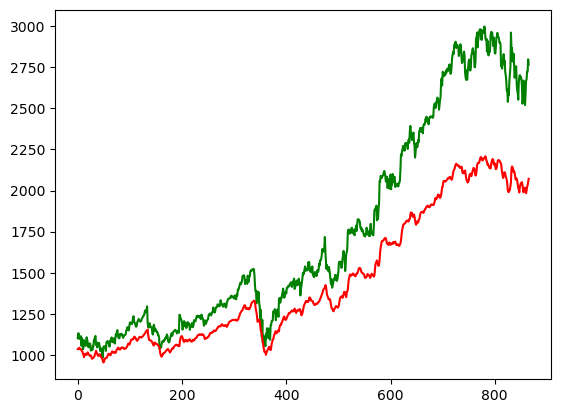

In [131]:
# Plot True vs Predicted Closing Prices
time = np.array([i for i in range(len(true_stocks))])
plt.plot(time, true_stocks[:, 3], color='green', label='True Close')  # True close prices
plt.plot(time, original_predictions[:, 3], color='red', label='Predicted Close') 

In [101]:
plt.savefig('analysis.png')


<Figure size 640x480 with 0 Axes>